# Quotient Filter

In [25]:
import hashlib
import math
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [26]:
def get_hashes(item, size_arr, count=1):
    # Преобразуем входной элемент в строку и затем в число (например, используя хеш Python)
    seed_value = hash(item) % 442
    hashes = []

    def truncate_to_power_of_two(arr):
        # Находим максимальную степень двойки, не превышающую длину массива
        length = len(arr)
        power = math.floor(math.log2(length))
        
        # Обрезаем массив до найденной длины
        return str(arr[:power]) 

    # Создаем три разных хеша с разными seed-ами
    def generate_binary_hash(seed, length=size_arr):
        np.random.seed(seed)  # Задаем seed для детерминированности
        binary_string = ''.join(str(np.random.randint(0, 2)) for _ in range(length))

        return truncate_to_power_of_two(binary_string)
    
    # Генерируем три разных хеша
    for i in range(count):
        hashes.append(generate_binary_hash(seed_value + i))

    return hashes

In [27]:
class QuotientFilter:
    def __init__(self, q_bits: int, r_bits: int):
        self.q_bits = q_bits
        self.r_bits = r_bits
        self.size = 4 ** q_bits  # Размер таблицы (степень двойки)
        self.remainders = [None] * self.size  # Остатки (remainders)
        
        self.is_occupied = [False] * self.size  # Занятые ячейки
        self.is_continuation = [False] * self.size  # Продолжение цепочки
        self.is_shifted = [False] * self.size  # Сдвинутые элементы

    def hash_element(self, element):
        """Вычисляет хэш элемента и делит его на частное (q) и остаток (r)."""
        hash_val = get_hashes(element, size_arr=self.q_bits + self.r_bits).pop() # Используем встроенный хэш Python (можно заменить на другую функцию)
        q = int(hash_val[:self.q_bits], 2)
        r = int(hash_val[self.q_bits:], 2)
        return q, r
    
    def find_first_freedom(self, q):
        while True:
            q += 1
            if self.remainders[q% self.size] is None:
                return q
            else:
                return False
            
    def find_first_shifted(self, q):
        while True:
            q += 1
            if self.is_shifted[q% self.size] is True:
                return q, True
            elif self.remainders[q% self.size] is None:
                return q, None
            elif self.is_occupied[q% self.size] is True:
                return q, 'occupied'

    def move_all_elements_right(self, q):
        # Начинаем с последней ячейки массива
        for i in range(self.size - 1, q, -1):
            current_idx = i % self.size  # Текущая ячейка
            prev_idx = (i - 1) % self.size  # Предыдущая ячейка

            # Копируем данные из предыдущей ячейки в текущую
            self.remainders[current_idx] = self.remainders[prev_idx]
            self.is_occupied[current_idx] = self.is_occupied[prev_idx]
            self.is_continuation[current_idx] = self.is_continuation[prev_idx]
            self.is_shifted[current_idx] = self.is_shifted[prev_idx]

        # Очищаем ячейку q+1 после сдвига
        clear_idx = (q + 1) % self.size
        self.remainders[clear_idx] = None
        self.is_occupied[clear_idx] = False
        self.is_continuation[clear_idx] = False
        self.is_shifted[clear_idx] = False

    def does_exist_need_el(self, q, r):
        if self.remainders[q] == r: 
            return True
        while self.is_occupied[(q+1) % self.size] != True:
            if self.remainders[q% self.size] == r:
                return True
            q += 1
        return False
    
    def find_need_el(self, q, r):
        if self.remainders[q] == r: 
            return q
        while self.is_occupied[(q+1) % self.size] != True:
            if self.remainders[q% self.size] == r:
                return q
            q += 1
        return None
    
    def contains(self,element):
        q,r = self.hash_element(element)
        if self.is_occupied[q] is True:
            return self.does_exist_need_el(q,r)
        else:
            new_q, find_shift = self.find_first_shifted(q)
            return self.does_exist_need_el(new_q,r)

    def insert(self, element):
        q,r = self.hash_element(element)

        if self.is_occupied[q] == False and self.is_continuation[q] == False:
            self.remainders[q], self.is_occupied[q] = r, True

        elif self.is_occupied[q] == True:
            new_q = self.find_first_freedom(q)
            if new_q != False:
                self.remainders[new_q], self.is_continuation[new_q] = r, True
            else:
                self.move_all_elements_right(q)
                self.remainders[(q+1) % self.size], self.is_continuation[(q+1) % self.size] = r, True

        elif self.is_continuation[q] == True:
            new_q, find_shift = self.find_first_shifted(q)
            if find_shift is True:
                new_q = self.find_first_freedom(new_q)
                if new_q is not False:
                    self.remainders[new_q], self.is_continuation[new_q] = r, True

                else:
                    self.move_all_elements_right(q)
                    self.remainders[(q+1) % self.size], self.is_continuation[(q+1) % self.size] = r, True

            elif find_shift is False:
                self.remainders[new_q], self.is_occupied[new_q], self.is_shifted[new_q] = r, True, True
            elif find_shift == 'occupied':
                self.move_all_elements_right(new_q)
                self.remainders[new_q], self.is_occupied[new_q], self.is_shifted[new_q] = r, True, True

    def move_some_elements_left(self, q):
        length, find_shift = self.find_first_shifted(q)
        length -= q

        # Начинаем с последней ячейки массива
        for i in range(q, q + length):
            current_idx = i % self.size  # Текущая ячейка
            next_idx = (i + 1) % self.size  # Следующая ячейка

            # Копируем данные из следующей ячейки в текущую
            self.remainders[current_idx] = self.remainders[next_idx]
            self.is_occupied[current_idx] = self.is_occupied[next_idx]
            self.is_continuation[current_idx] = self.is_continuation[next_idx]
            self.is_shifted[current_idx] = self.is_shifted[next_idx]

        # Очищаем последнюю ячейку после сдвига
        clear_idx = (q + length) % self.size
        self.remainders[clear_idx] = None
        self.is_occupied[clear_idx] = False
        self.is_continuation[clear_idx] = False
        self.is_shifted[clear_idx] = False

    def remove(self, element):
        q,r = self.hash_element(element)
        if self.is_occupied[q] == True:
            new_q = self.find_need_el(q, r)
            self.move_some_elements_left(new_q)
        else:
            new_q, find_shift = self.find_first_shifted(q)
            self.move_some_elements_left(new_q)


In [28]:
qf = QuotientFilter(q_bits=4, r_bits=8) 

# Вставка элементов
qf.insert('apple')
qf.insert('banana')
qf.insert('grape')

# Проверка наличия элементов
print("Содержит ли 'apple':", qf.contains('apple'))  # True
print("Содержит ли 'banana':", qf.contains('banana'))  # True
print("Содержит ли 'grape':", qf.contains('grape'))  # False

qf.remove('grape')
print("Содержит ли 'grape' после удаления:", qf.contains('grape'))  # False

ValueError: invalid literal for int() with base 2: ''

In [ ]:
def false_positive_rate(r_bits: int, n: int, q_bits: int) -> float:
    """
    Вычисляет вероятность ложноположительных срабатываний для Quotient Filter.

    :param r_bits: Количество бит для остатка (remainder).
    :param n: Количество элементов в таблице.
    :param q_bits: Количество бит для частного (quotient).
    :return: Вероятность ложноположительных срабатываний (в долях единицы).
    """
    if r_bits <= 0:
        raise ValueError("r_bits должен быть положительным числом.")
    if q_bits <= 0:
        raise ValueError("q_bits должен быть положительным числом.")
    if n < 0:
        raise ValueError("n не может быть отрицательным числом.")

    # Размер таблицы
    size = 4 ** q_bits

    # Проверяем, чтобы n не превышал размер таблицы
    if n > size:
        return 1.0  # Если элементов больше, чем ячеек, все проверки будут ложноположительными

    # Вероятность ложноположительных срабатываний
    false_positive_probability = 1 / (2 ** r_bits)

    return false_positive_probability

In [ ]:
probability = false_positive_rate(qf.r_bits, qf.size, qf.q_bits)
print(f"Процент ложноположительных срабатываний: {probability * 100:.2f}%")

Процент ложноположительных срабатываний: 0.39%


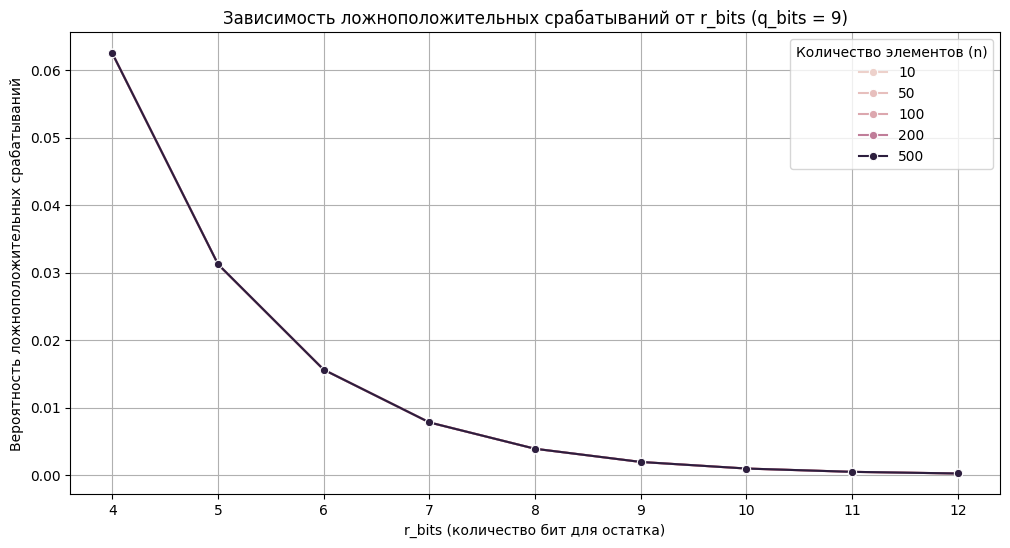

,r_bits,n,False Positive Rate
0,4,10,0.0625
1,4,50,0.0625
2,4,100,0.0625
3,4,200,0.0625
4,4,500,0.0625


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def false_positive_rate(r_bits: int, n: int, q_bits: int) -> float:
    """
    Вычисляет вероятность ложноположительных срабатываний для Quotient Filter.

    :param r_bits: Количество бит для остатка (remainder).
    :param n: Количество элементов в таблице.
    :param q_bits: Количество бит для частного (quotient).
    :return: Вероятность ложноположительных срабатываний (в долях единицы).
    """
    if r_bits <= 0:
        raise ValueError("r_bits должен быть положительным числом.")
    if q_bits <= 0:
        raise ValueError("q_bits должен быть положительным числом.")
    if n < 0:
        raise ValueError("n не может быть отрицательным числом.")

    # Размер таблицы
    size = 2 ** q_bits

    # Проверяем, чтобы n не превышал размер таблицы
    if n > size:
        return 1.0  # Если элементов больше, чем ячеек, все проверки будут ложноположительными

    # Вероятность ложноположительных срабатываний
    false_positive_probability = 1 / (2 ** r_bits)

    return false_positive_probability

# Параметры для анализа
r_bits_values = range(4, 13)  # Значения r_bits от 4 до 12
n_values = [10, 50, 100, 200, 500]  # Различные значения количества элементов
q_bits = 9  # Фиксированное значение q_bits (размер таблицы = 2^10 = 1024)

# Создание DataFrame для хранения результатов
data = []
for r_bits in r_bits_values:
    for n in n_values:
        probability = false_positive_rate(r_bits, n, q_bits)
        data.append({"r_bits": r_bits, "n": n, "False Positive Rate": probability})

df = pd.DataFrame(data)

# Построение графиков
plt.figure(figsize=(12, 6))
# Линейный график зависимости от r_bits для фиксированных значений n
sns.lineplot(data=df, x="r_bits", y="False Positive Rate", hue="n", marker="o")
plt.title(f"Зависимость ложноположительных срабатываний от r_bits (q_bits = {q_bits})")
plt.xlabel("r_bits (количество бит для остатка)")
plt.ylabel("Вероятность ложноположительных срабатываний")
plt.legend(title="Количество элементов (n)")
plt.grid(True)
plt.show()
df.head()

In [ ]:
# Построение графика: Линейный график
plt.figure(figsize=(12, 8))
for n in n_values:
    subset = df[df['n'] == n]
    plt.plot(subset['r_bits'], subset['False Positive Rate'], 
             marker='o', label=f'n = {n}')

plt.xlabel('r_bits (Number of Remainder Bits)')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate vs r_bits for Different n (q_bits = 9)')
plt.legend(title='Number of Elements (n)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.show()

# Построение тепловой карты
plt.figure(figsize=(10, 6))
pivot_table = df.pivot(index='n', columns='r_bits', values='False Positive Rate')
sns.heatmap(pivot_table, annot=True, fmt='.2e', cmap='YlOrRd', cbar_kws={'label': 'False Positive Rate'})
plt.xlabel('r_bits')
plt.ylabel('Number of Elements (n)')
plt.title('Heatmap of False Positive Rate (q_bits = 9)')
plt.show()

# Вывод числовой таблицы
print("\nТаблица вероятностей ложноположительных срабатываний:")
print(pivot_table)